In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

In [2]:
def maximize(f, a, b, args):
    objective = lambda x: -f(x, *args)
    res = minimize_scalar(objective, bounds=(a,b), method="bounded")
    maximizer, maximum = res.x, -res.fun
    return maximizer, maximum

In [3]:
class OptimalGrowthModel:
    def __init__(self, u, f, beta=0.96, mu=0, s=0.1, grid_min=1e-4, grid_max=4, grid_size=120,
                 shock_size=250, seed=1234):
        self.u, self.f, self.beta, self.mu, self.s = u, f, beta, mu, s
        self.grid = np.linspace(grid_min, grid_max, grid_size)

        # Shocks are precomputed and stored here; seed makes results replicable
        # np.random.randn gives normally distributes values in [0,1); size gives the number of draws
        np.random.seed(seed)
        self.shocks = np.exp(mu + s * np.random.randn(shock_size))

    def state_action_value(self, c, y, v_array):
        v = interp1d(self.grid, v_array)
        return self.u(c) + self.beta * np.mean(v(self.f(y-c) * self.shocks))

In [4]:
def T(v, og):
    v_greedy = np.empty_like(v) # Contains the consumption value
    v_new = np.empty_like(v) # Contains value of value function


    for i in range(len(og.grid)):
        y = og.grid[i]
        v_greedy[i], v_new[i]  = maximize(og.state_action_value, 1e-10, y, (y, v))

    return v_greedy, v_new

In [5]:
alpha = 0.4
def fcd(k):
    return k ** alpha

og = OptimalGrowthModel(np.log, fcd)

In [6]:
def v_star(y, α, β, μ):
    """
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

def σ_star(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y

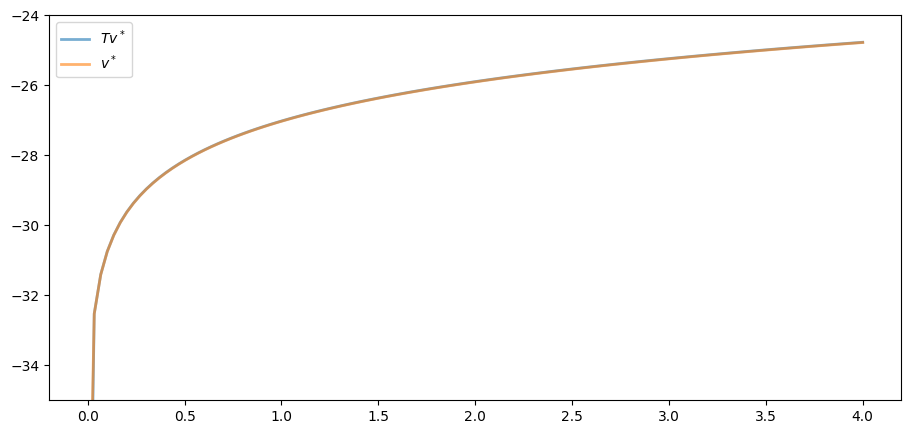

In [7]:
grid = og.grid

v_init = v_star(og.grid, alpha, og.beta, og.mu)    # Start at the solution
v_greedy, v = T(v_init, og)             # Apply T once

fig, ax = plt.subplots()
ax.set_ylim(-35, -24)
ax.plot(grid, v, lw=2, alpha=0.6, label='$Tv^*$')
ax.plot(grid, v_init, lw=2, alpha=0.6, label='$v^*$')
ax.legend()
plt.show()

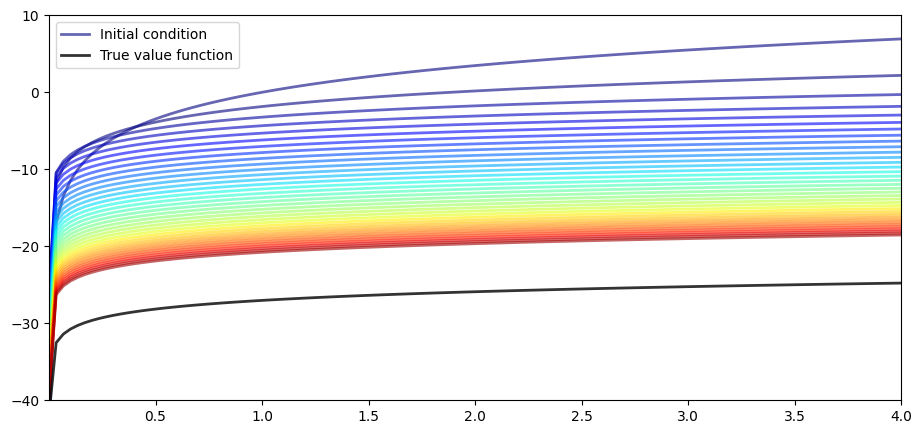

In [8]:
v = 5 * np.log(og.grid)
n = 35

fig, ax = plt.subplots()

ax.plot(og.grid, v, color=plt.cm.jet(0), lw=2, alpha=0.6, label='Initial condition')

for i in range(n):
    v_greedy, v = T(v, og)
    ax.plot(og.grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.plot(og.grid, v_star(og.grid, alpha, og.beta, og.mu), 'k-', lw=2,
    alpha=0.8, label='True value function')

ax.legend()
ax.set(ylim=(-40, 10), xlim=(np.min(og.grid), np.max(og.grid)))
plt.show()

In [9]:
def solve_model(og, tol=1e-4, max_iter=1000, verbose=True, print_skip=25):
    v = og.u(og.grid)
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        v_greedy, v_new = T(v, og)
        error = np.max(np.abs(v - v_new))
        i += 1
        v = v_new

        if verbose and i % print_skip == 0:
            print(f"iteration {i}, error {error}")

    if error > tol:
        print("Iteration did not converge")
    else:
        print(f"Converged in {i} steps")

    return v_greedy, v_new

In [10]:
v_greedy, v_solution = solve_model(og)

iteration 25, error 0.40975776844490497
iteration 50, error 0.1476753540823772
iteration 75, error 0.05322171277214238
iteration 100, error 0.01918093054865011
iteration 125, error 0.006912744396029069
iteration 150, error 0.0024913303848101975
iteration 175, error 0.000897867291303811
iteration 200, error 0.0003235884239707332
iteration 225, error 0.00011662020561686859
Converged in 229 steps


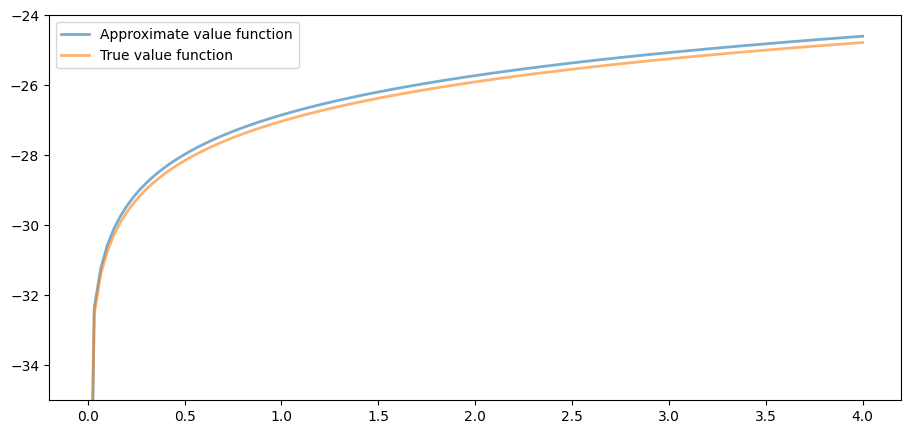

In [11]:
fig, ax = plt.subplots()

ax.plot(og.grid, v_solution, lw=2, alpha=0.6,
        label='Approximate value function')

ax.plot(og.grid, v_star(og.grid, alpha, og.beta, og.mu), lw=2,
        alpha=0.6, label='True value function')

ax.legend()
ax.set_ylim(-35, -24)
plt.show()